Notebook per fare il Training e il Testing del modello per la classe di centralità 10-40 % per fare il confronto con i risultati dell'analisi standard. Nella prima parte del notebook Training e Testing, nella seconda viene stimata la Significance che si otterrebbe misurando lo yield. 

In [1]:
%pylab inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pickle

%run ../Optimization/analysis_utils.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
training = False

In [3]:
from scipy.stats import norm

In [4]:
Nev_010=45070038

## Data preliminary

Carico i dati, defisco le variabili su cui fare Training e preparo il Training Set.

In [5]:
df_ML = pd.read_pickle('df_ML.pkl')
bkg = df_ML.query('y==0')
sig = df_ML.query('y==1')

In [6]:
data = pd.concat([bkg,sig],ignore_index=True)
data = data.sample(frac=1)

In [7]:
training_columns = [ 'V0CosPA','ProngsDCA', 'DistOverP','ArmenterosAlpha','NpidClustersHe3','V0pt','TPCnSigmaHe3']

In [8]:
df = data
traindata,testdata,ytrain,ytest = train_test_split(df, df['y'], test_size=0.5)

Plotto le variabili di Training del segnale e del fondo come confronto e la matrice delle correlazioni.

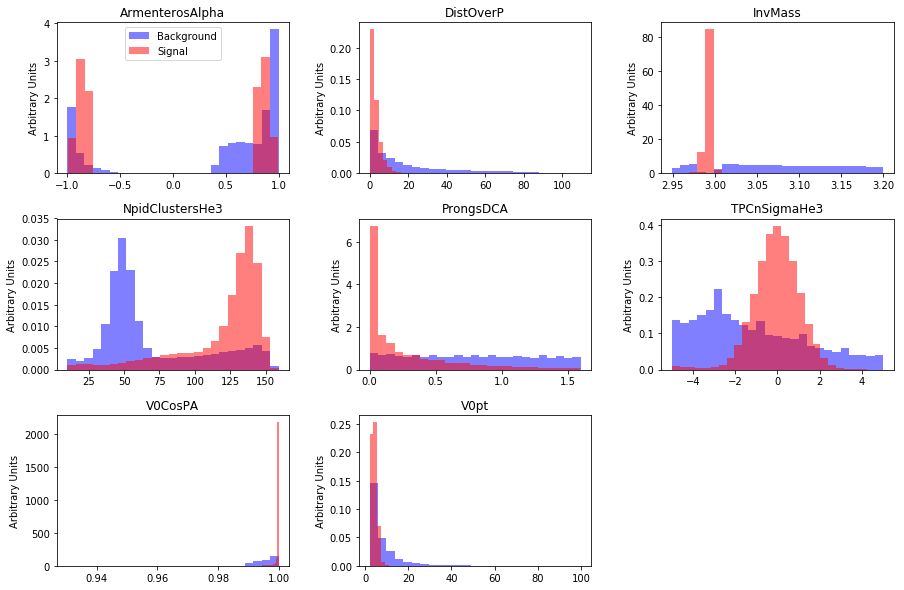

In [9]:
plot_distr(df,training_columns+['InvMass'])

## Training

For using pre-trained models skip to the Testing part.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params_def = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist',
    'scale_pos_weight': 10}


In [ ]:
def optimize_params(dtrain,par):
    %run analysis_utils.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

In [ ]:
dtrain = xgb.DMatrix(data=np.asarray(traindata[training_columns]), label=ytrain, feature_names=training_columns)
n_round = optimize_params(dtrain,params_def)
model_cent_integr = xgb.train(params_def, dtrain,num_boost_round=n_round) 

In [ ]:
# saving the model
pickle.dump(model_cent_integr,open("model_0_10.pkl", "wb"))

## Testing

If you skip the Training start from here.

In [10]:
if training:
    model = model_cent_integr
else:
    model = pickle.load(open("model_0_10.pkl", "rb"))

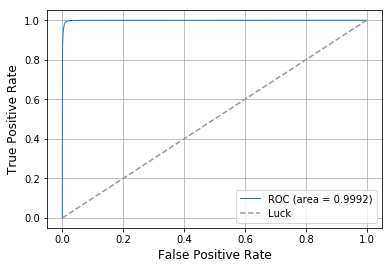

In [11]:
dtest = xgb.DMatrix(data=testdata[training_columns])
y_pred = model.predict(dtest,output_margin=True)
plot_roc(ytest,y_pred)

In [ ]:
from scipy import stats
stats.ks_2samp(ytrain,ytest)

Ks_2sampResult(statistic=0.9796311390173772, pvalue=0.0)


(1e-05, 1)

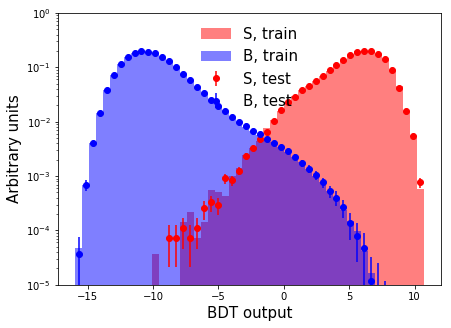

In [12]:
plot_output_train_test(model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True,log=True,location=9)
plt.ylim([10**-5,10**0])

Ks_2sampResult(statistic=0.9796311390173772, pvalue=0.0)


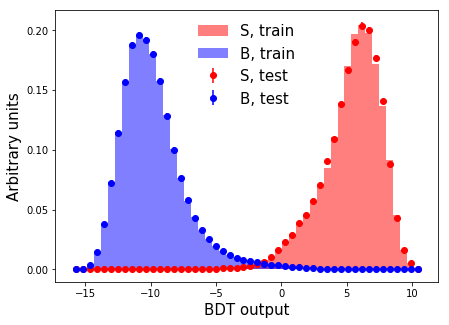

In [14]:
plot_output_train_test(model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

## BDT Efficiency 

Calcolo l'efficienza del modello in funzione dello Score.

<Figure size 432x288 with 0 Axes>

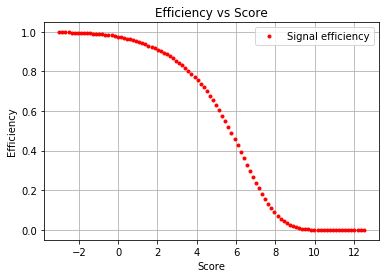

<Figure size 432x288 with 0 Axes>

In [15]:
testdata.eval('Score = @y_pred',inplace=True)
efficiency_array=EfficiencyVsCuts(testdata)
plt.figure() 

In [ ]:
np.save("efficiency_0_10_array",efficiency_array)

# Significance Scan Vs pT

Scan della Significance Vs BDT Score negli stessi bin di pT in cui Stefano ha estratto lo yield doppio differenziale per confrontare la massima sign. ottenibile con il BDT con la sign. ottenuta con il metodo standard. Eventi in classe di centralità 10-40%.

### Carico i dati  in centralità 0_10%

In [16]:
df_18r = pd.read_pickle('df_Sig_data.pkl')
df_18r = df_18r.astype('float')

### Funzioni di servizio

In [17]:
def SignificanceError(sig,bkg,i):
    yield_meas = [2.6*1.e-5,2.6*8.e-6,2.6*4.e-6,2.6*9.e-7]
    err_sig=np.sqrt(yield_meas[i])/(yield_meas[i])*sig
    err_bkg=sqrt(bkg)
    err_sig=sqrt(sig)
    err_1=(sqrt(sig+bkg)-sig*(1/(2*sqrt(sig+bkg))))/(sig+bkg)
    err_2=sig/(2*(sig+bkg)**(3/2))
    return abs(err_1)*err_sig+abs(err_2)*err_bkg

In [18]:
def ExpectedSignal(eff_bdt, i):
    n_ev = 45070038
    yield_meas = [2.6*1e-5,2.6*8e-6,2.6*4e-6,2.6*9e-7] # values taken from S.Trogolo PhD Thesis
    eff_V0 = [0.19,0.29,0.38,0.47] # values computed in eff2body.cc macro
    dpT = [1,1,1,4]
    return int(round(n_ev*yield_meas[i]*dpT[i]*eff_V0[i]*eff_bdt))

In [19]:
def SignificanceScan(df, pT_min, pT_max, i_pT,custom=False):    
    signal_array = []
    significance_array = []
    custom_significance_array = []
    error_array=[]
    score_list = np.linspace(-3,12.5,100)
    index = 0
    for i in score_list:
        df_score = df.query('Score>@i and V0pt>=@pT_min and V0pt<=@pT_max')
        counts,bins = np.histogram(df_score['InvMass'],bins=26,range=[2.97,3.05]);
        bin_centers = 0.5*(bins[1:]+bins[:-1])
        sidemap = (bin_centers<2.9923-3*0.0025) + (bin_centers>2.9923+3*0.0025)
        massmap = logical_not(sidemap)
        bins_side = bin_centers[sidemap]
        counts_side = counts[sidemap]
        h, residuals, _, _, _ = polyfit(bins_side,counts_side,2,full=True)
        chisq_dof = residuals / (len(bins_side) - 3)
        y = polyval(h,bins_side)
        signal = ExpectedSignal(efficiency_array[index], i_pT)
        bkg = sum(polyval(h,bin_centers[massmap]))
        significance = signal/sqrt(signal+bkg+1e-10)
        signal_array.append(signal)
        error_array.append(SignificanceError(signal,bkg,i_pT))
        significance_array.append(significance)
        custom_significance = significance*efficiency_array[index]
        custom_significance_array.append(custom_significance)
        index += 1
    significance_array=asarray(significance_array)
    error_array=asarray(error_array)
        
    if custom==True:
        max_index = np.argmax(custom_significance_array)
    else:
        max_index = np.argmax(significance_array)
        
    max_score = score_list[max_index]
    sign = significance_array[max_index]
    custom_sign = custom_significance_array[max_index]
    ryield = signal_array[max_index]
    df_cut = df.query('Score>@max_score and V0pt>=@pT_min and V0pt<=@pT_max')
    counts_mc_0 = norm.pdf(bin_centers,loc=2.992,scale=0.0025)
    counts_mc = (ryield/sum(counts_mc_0))*counts_mc_0
    counts_data,_ = np.histogram(df_cut['InvMass'],bins=26,range=[2.97,3.05]);
    h = polyfit(bins_side,counts_data[sidemap],2)
    counts_bkg = polyval(h,bin_centers)
    counts_tot = counts_bkg+counts_mc
    fig, axs = plt.subplots(1,2, figsize=(12, 4)) 
    axs[0].set_xlabel('Score')
    axs[0].tick_params(axis="x", direction="in")
    axs[0].tick_params(axis="y", direction="in")
    
    
    if custom==True:
        axs[0].set_ylabel('Significance x Efficiency')
        axs[0].plot(score_list,custom_significance_array,'b',label='Expected significance')
        a=custom_significance_array-error_array*efficiency_array
        b=custom_significance_array+error_array*efficiency_array
        axs[0].fill_between(score_list,a,b,facecolor='deepskyblue',label=r'$ \pm 1\sigma$')
        axs[0].grid()
        
    else:
        axs[0].set_ylabel('Significance')
        axs[0].plot(score_list,significance_array,'b',label='Expected significance')
        a=significance_array-error_array
        b=significance_array+error_array
        axs[0].fill_between(score_list,a,b,facecolor='deepskyblue',label=r'$ \pm 1\sigma$')
        axs[0].grid()
    
    axs[0].legend(loc='upper left')
    plt.suptitle(r"%1.f $ \leq \rm{p}_{T} \leq $ %1.f, Cut Score = %0.2f, Significance/Events = %0.4f$x10^{-7}$, Significance x Efficiency = %0.2f , Raw yield = %0.2f" %(pT_min,pT_max,max_score,(sign/45070038)*1e7,custom_sign,ryield))
    
    yerr_data = sqrt(counts_data[sidemap])
    yerr_tot = sqrt(counts_tot[massmap])
    
    axs[1].errorbar(bin_centers[sidemap],counts_data[sidemap],yerr=yerr_data,fmt='.',ecolor='k',color='b',elinewidth=1.,label='Data')
    axs[1].errorbar(bin_centers[massmap],counts_tot[massmap],yerr=yerr_tot,fmt='.',ecolor='k',color='r',elinewidth=1.,label='Pseudodata')    
    axs[1].plot(bin_centers[sidemap],counts_bkg[sidemap],'g-',label='Background fit')
    x=np.linspace(2.9923-3*0.0025,2.9923+3*0.0025,1000)
    gaussian_counts=norm.pdf(x,loc=2.992,scale=0.0025)
    gaussian_counts=(ryield/sum(counts_mc_0))*gaussian_counts+polyval(h,x)
    axs[1].plot(x,gaussian_counts,'y',color='orange',label='Gaussian model')
    axs[1].set_xlabel(r"$m_{\ ^{3}He+\pi^{-}}$")
    axs[1].set_ylabel(r"Events /  $3.6\ \rm{MeV}/c^{2}$") 
    axs[1].tick_params(axis="x", direction="in")
    axs[1].tick_params(axis="y", direction="in")    
    axs[1].legend(loc=(0.37,0.47))
    plt.ylim(ymin=0)
    textstr = '\n'.join((
    r"%1.f GeV/c $ \leq \rm{p}_{T} < $ %1.f GeV/c " %(pT_min,pT_max,),
    r' Significance/Events = %0.4f$x10^{-7}$' % ((sign/45070038)*1e7, )))
    props = dict(boxstyle='round',facecolor='white', alpha=0,)
    axs[1].text(0.37, 0.95, textstr, transform=axs[1].transAxes,
        verticalalignment='top', bbox=props)
    plt.show()
    plt.savefig('fig{}.pdf'.format(i))
    return max_score

/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/fmazzasc/.local_pip/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 432x288 with 0 Axes>

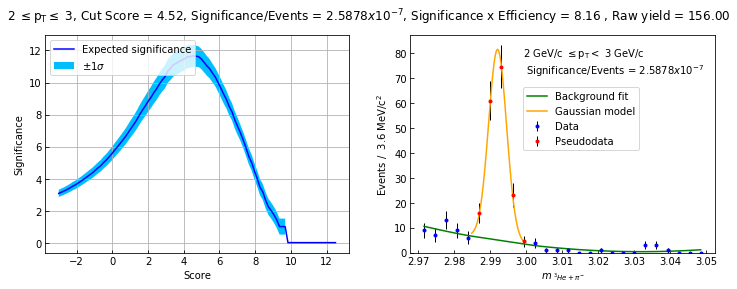

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

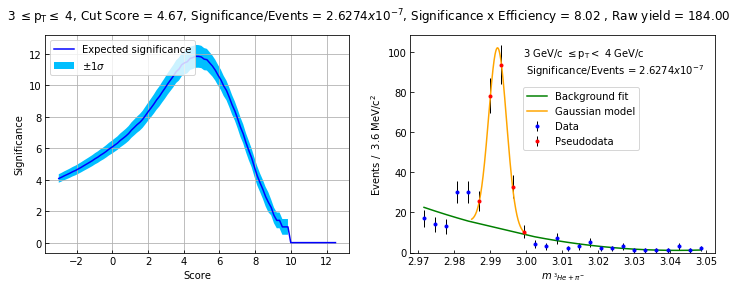

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

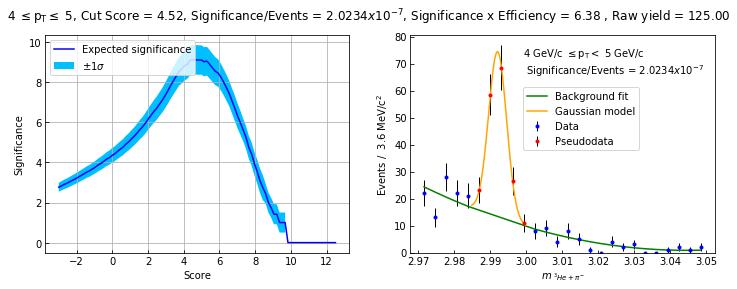

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

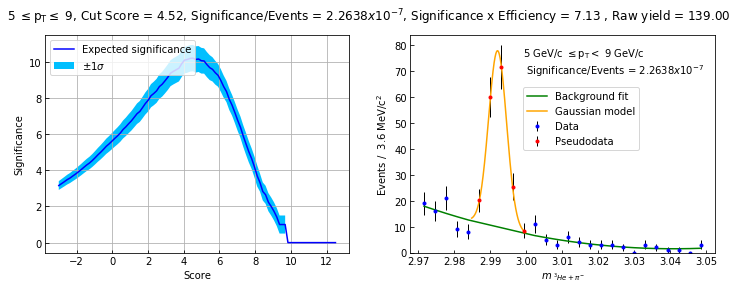

<Figure size 432x288 with 0 Axes>

In [20]:
pT_list = [[2,3],[3,4], [4,5],[5,9]]
best_score_list=[]

for i in range(0,4):
    plt.figure();
    dtest = xgb.DMatrix(data=df_18r[training_columns],silent=True)
    df_18r['Score'] = model.predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_18r,pT_list[i][0],pT_list[i][1],i))
    del dtest

/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


<Figure size 432x288 with 0 Axes>

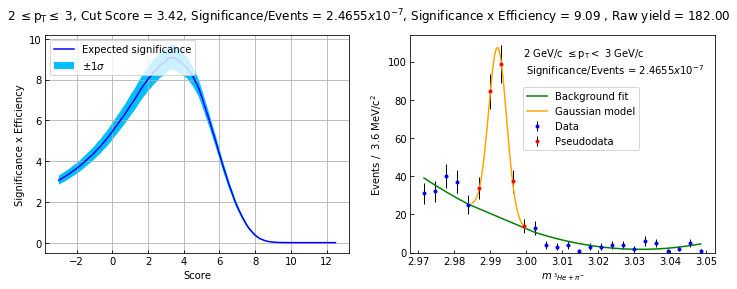

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

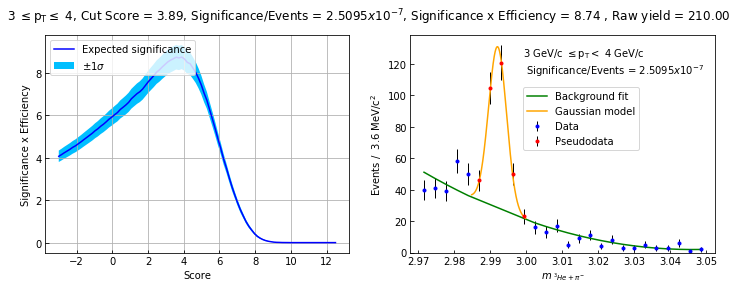

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

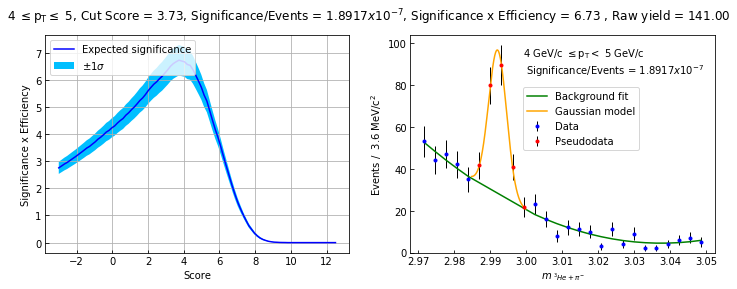

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

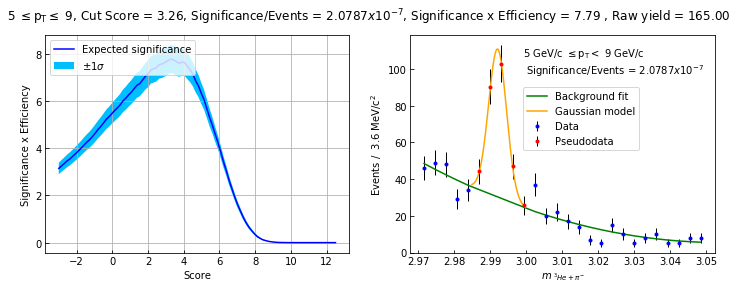

<Figure size 432x288 with 0 Axes>

In [21]:
pT_list = [[2,3],[3,4],[4,5],[5,9]]
best_score_list=[]

for i in range(0,4):
    plt.figure();
    dtest = xgb.DMatrix(data=df_18r[training_columns],silent=True)
    df_18r['Score'] = model.predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_18r,pT_list[i][0],pT_list[i][1],i,True))
    del dtest

###   test data

In [22]:
from scipy.optimize import curve_fit

In [23]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [24]:
def TestOnData(df,score,pt):
    df_score = df.query('Score>@score and V0pt>=@pt[0] and V0pt<=@pt[1]')
    counts,bins = np.histogram(df_score['InvMass'],bins=26,range=[2.97,3.05]);
    bin_centers = 0.5*(bins[1:]+bins[:-1])
    sidemap = (bin_centers<2.9923-3*0.0025) + (bin_centers>2.9923+3*0.0025)
    massmap = logical_not(sidemap)
    bins_side = bin_centers[sidemap]
    counts_side = counts[sidemap]
    h = polyfit(bins_side,counts_side,2)
    y = polyval(h,bins_side)
    counts_bkg = polyval(h,bin_centers[massmap]) 
    counts_sig=counts[massmap]-counts_bkg
    popt, pcov = curve_fit(gauss_function, bin_centers[massmap],counts_sig, p0 = [0, 2.9923, 0.0025])
    x=linspace(bin_centers[massmap][0]-0.01,bin_centers[massmap][-1]+0.01,100)
    x_bkg=polyval(h,x)
    plt.plot(x, gauss_function(x, *popt)+x_bkg,'b-',label='Gaussian model')
    plt.plot(bin_centers[massmap],counts[massmap],'r.',label='Signal region')
    plt.plot(bin_centers[sidemap],y,'g-',label='Sidebands fit')
    plt.plot(bin_centers[sidemap],counts[sidemap],'y.',label='Background rergion')
    tot_sig=sum(counts_sig)
    tot_bkg=sum(counts_bkg)

    plt.xlabel(r"$m_{\ ^{3}He+\pi^{-}}$")
    plt.ylabel(r"Events /  $3.6\ \rm{MeV}/c^{2}$") 
    plt.tick_params(axis="x", direction="in")
    plt.tick_params(axis="y", direction="in")  
    textstr =r"%1.f GeV/c $ \leq \rm{p}_{T} < $ %1.f GeV/c " %(pt[0],pt[1])
    props = dict(boxstyle='round',facecolor='white', alpha=0,)
    plt.title(textstr)
    plt.legend()
    print("Significance/Events = " , tot_sig/sqrt(tot_bkg+tot_sig)/45000000*1e7)
    print("S/B = " ,tot_sig/tot_bkg)
    print("Raw yield = " , tot_sig)

        

In [25]:
df_18r = pd.read_pickle('df_Sig_data.pkl')
df_18r = df_18r.astype('float')
dm=xgb.DMatrix(data=df_18r[training_columns],silent=True)
df_18r['Score']=model.predict(dm,output_margin=True)

Significance/Events =  1.0639480886933823
S/B =  3.4778445738290906
Raw yield =  29.513774233681033


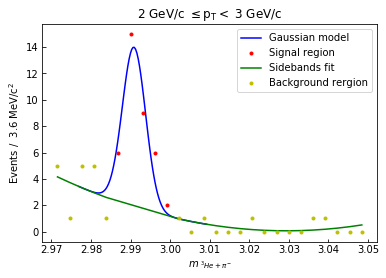

In [38]:
TestOnData(df_18r,5,[2,3])

Significance/Events =  1.6427477567745261
S/B =  2.1022852596150714
Raw yield =  80.64118060027613


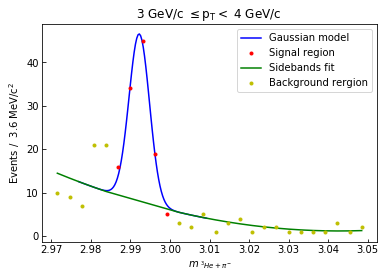

In [39]:
TestOnData(df_18r,5,[3,4])

Significance/Events =  1.5245216341566001
S/B =  1.8428626952567964
Raw yield =  72.60309202169083


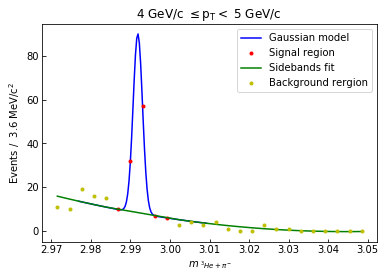

In [40]:
TestOnData(df_18r,5,[4,5])

Significance/Events =  1.7008935524701736
S/B =  1.5570295245685166
Raw yield =  96.20955195006536


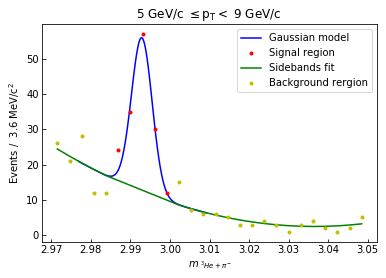

In [31]:
TestOnData(df_18r,4.2,[5,9])